# Breast histology images to classify invasive ductal carcinoma (IDC)
Invasive Ductal Carcinoma (IDC) which is also known as Infiltrating Ductal Carcinoma is a most common type of breast cancer in women that start growing in a milk duct. It has invaded the fibrous/fatty tissue or cells of the breast outside the duct.
IDC is demonstrating the 80% of the total breast cancer diagnoses that showns that it is most common form of breast cancer. The dataset we are going to use contains 5547 RGB images of breast histology where images shape is 50 X 50 X 3.
Classification of Cancerous Images Invasive Ductal Carcinoma (IDC) and Non Invasive Ductal Carcinoma (Non-IDC) will be performed using **CNN** and **Transfer Learning**. ***VGG16*** and ***Resnet*** architectures were used as transfer learning models.

**Data augmentation** is used to generate new images by rotating, manipulating, and zooming to reduce overfitting while training of the model which was not effective as i expected.
80% (training set) and 20% (testset) traning and test split was used to train and validate the model.

An accuracy of 82% on the validation data was achieved from training the model for 30 epochs with augmented data.







### **Importing esstential libraries and packages**

In [1]:
#Loading the libraries
import numpy as np
import matplotlib.pylab as plt
import itertools
import sklearn
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D
%matplotlib inline

### **Importing and reading the dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
X = np.load('/content/drive/MyDrive/X.npy') # images
Y = np.load('/content/drive/MyDrive/Y.npy') # labels associated to images (0 = non IDC, 1 = IDC)

### **Explore the dataset to understand its characteristics**

In [4]:
#Description of dataset
X = np.array(X)
Y = np.array(Y)
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


In [5]:
#Data shape
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (5547, 50, 50, 3)
Y shape:  (5547,)


**Data sample has shown below, the image will be labeled as 0 (non-IDC) or 1 (IDC).**

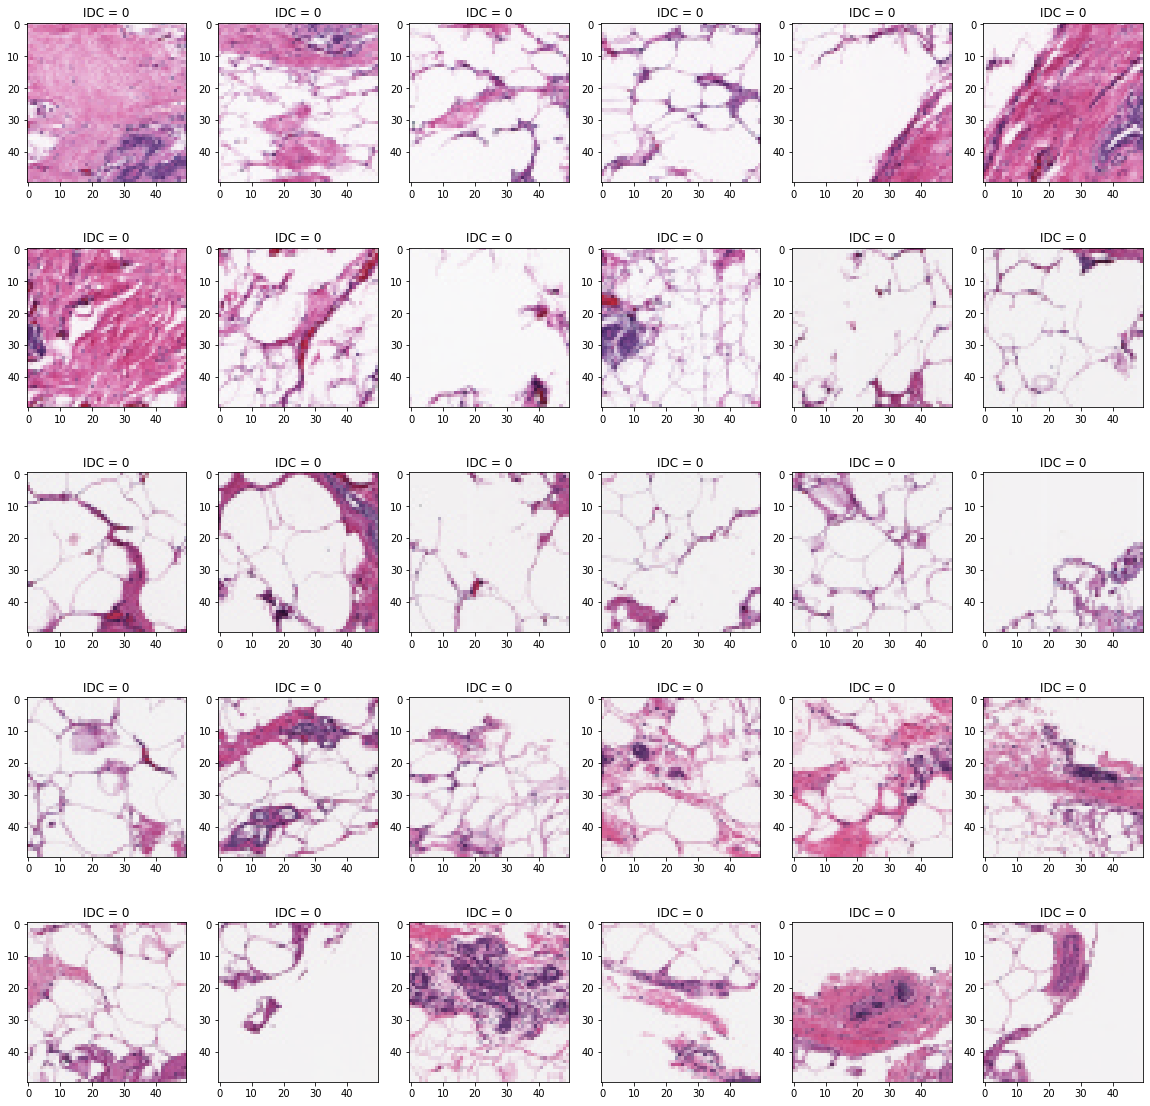

In [6]:
#Samples of Dataset by plotting few Images
Non_IDC = X[Y == 0] # 0 = Non IDC
IDC = X[Y == 1] # 1 = IDC

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%Y[i])
    plt.imshow(X[i])

 ### **Pre-process data to be suitable for building the model**

#### **Shuffling Data**
**In given dataset, data samples of images labeled as 0 (non-IDC) are before the data samples labeled as 1 (IDC) as few images are shown above. To avoid artificial data patterns, the dataset is randomly shuffled as follows:**

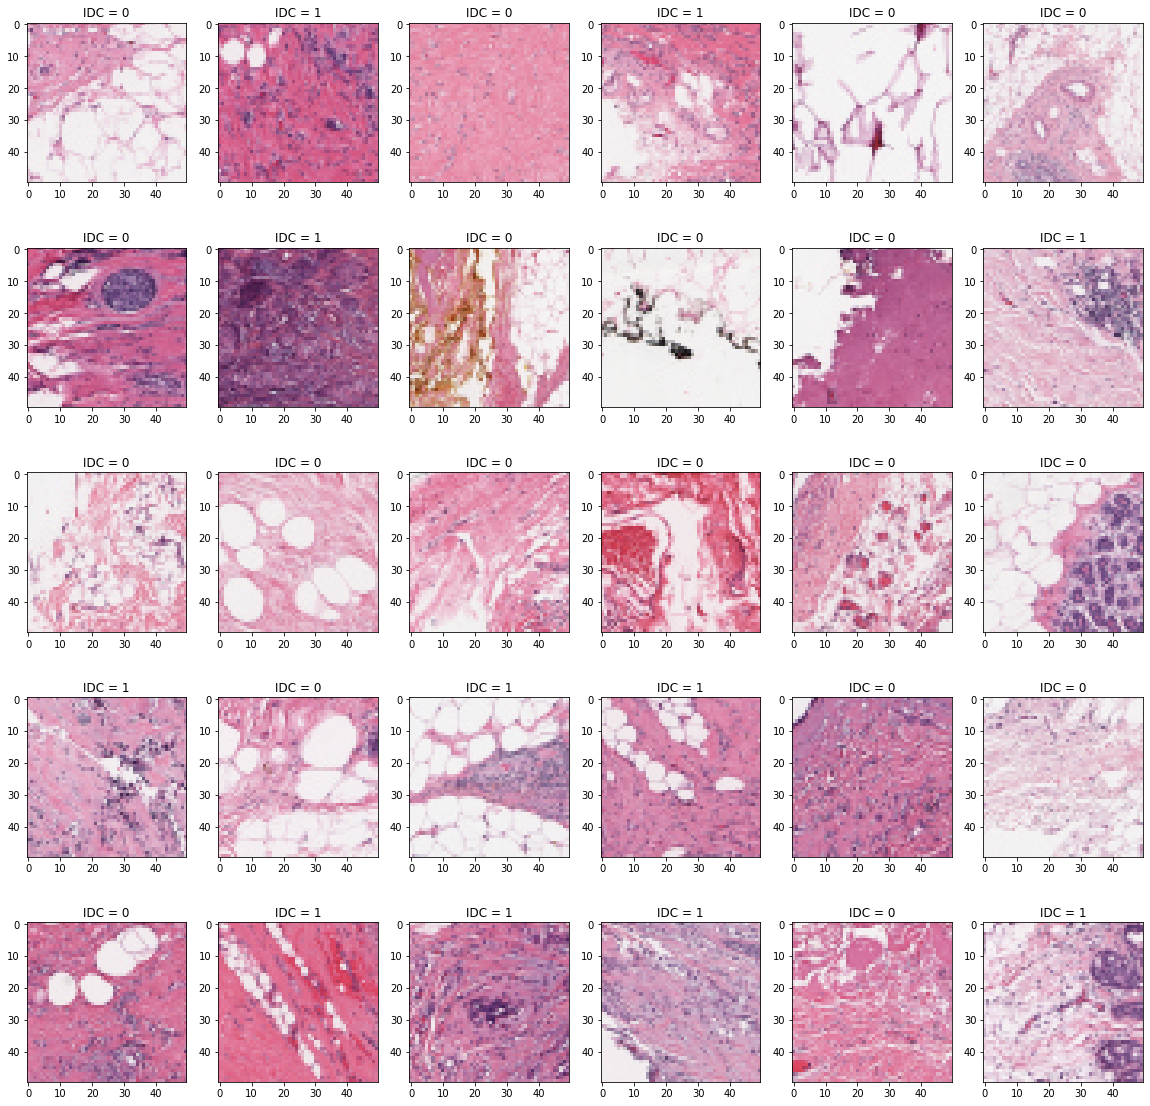

In [7]:
# Shuffling Data
perm_array = np.arange(len(X))
np.random.shuffle(perm_array)
X = X[perm_array]
Y = Y[perm_array]

# Plotting Some Images
imgs_0 = X[Y == 0] # 0 = Non IDC
imgs_1 = X[Y == 1] # 1 = IDC

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%Y[i])
    plt.imshow(X[i])

In [8]:
#Spliting dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1234)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4437, 50, 50, 3)
(4437,)
(1110, 50, 50, 3)
(1110,)


#### **Scaling/Normalizing the Data**
**The pixel values of IDC images ranges between [0, 255], therefore a traditional deep learning models works in an effective manner when the input data values ranges between [0, 1] or [-1, 1]. Scaling performed below to transform the pixel values of IDC images in the range of [0, 1].**

In [10]:
# normalize inputs from [0.0, 255.0] to end up with input in the range [0.0, 1.0]
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
X_train /= 255.0
X_test /= 255.0

# one-hot encoding of the labels
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# X_train = X_train / 255.
# X_test = X_test / 255.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4437, 50, 50, 3)
(4437, 2)
(1110, 50, 50, 3)
(1110, 2)


### **Fine Tuning Convolutional Neural Network (CNN)**
#### **CNN artitecture:**
Following CNN based neural network architecture is proposed:

input layer: [50, 50, 3]

Conv1 -> ReLu ->
MaxPool: [., 24, 24, 16]

Conv2 -> ReLu ->
MaxPool: [., 11, 11, 32]

Conv3 -> ReLu ->
MaxPool: [., 11, 11, 32]

Conv4 -> ReLu -> 
MaxPool: [., 1, 1, 64]


Flatten  [., 64] ->
Fully connected (FC) -> [., 64]

output layer: FC -> [., 2]


In [11]:
from typing import Sized
###2 conv and pool layers. with some normalization and drops in between.
size =50
INPUT_SHAPE = (size, size, 3)   #change to (SIZE, SIZE, 3)


model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=INPUT_SHAPE, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('sigmoid')) 

#Model Summary
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 32)        0

In [12]:
callback = EarlyStopping(monitor='val_loss', patience=10)
seed = 1234
np.random.seed(seed)
batch_sizee = 64
epochs = 100
# #Data augmentation
# datagen = ImageDataGenerator(zoom_range=0.05,      
#                              rotation_range=45,
#                              fill_mode="nearest",
#                              horizontal_flip = True,
#                              brightness_range=(0.5,1.5),
#                              vertical_flip=True)

# datagen.fit(X_train)
# #fit the model
# history = model.fit(datagen.flow(X_train,y_train,batch_size = batch_size),
#                                steps_per_epoch=(len(X_train)/batch_size),epochs=epochs,
#                                validation_data=(X_test,y_test),validation_steps=(len(X_test)/batch_size), callbacks=callback)
# print(len(history.history['loss']))

#fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=batch_sizee, callbacks=callback)
print(len(history.history['loss']))


Epoch 1/100
70/70 [==============================] - 4s 14ms/step - loss: 0.6900 - accuracy: 0.5438 - val_loss: 0.6739 - val_accuracy: 0.7144
Epoch 2/100
70/70 [==============================] - 0s 7ms/step - loss: 0.6267 - accuracy: 0.6797 - val_loss: 0.6036 - val_accuracy: 0.7018
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 0.5928 - accuracy: 0.7122 - val_loss: 0.5805 - val_accuracy: 0.7495
Epoch 4/100
70/70 [==============================] - 0s 7ms/step - loss: 0.5864 - accuracy: 0.7135 - val_loss: 0.6328 - val_accuracy: 0.6342
Epoch 5/100
70/70 [==============================] - 0s 7ms/step - loss: 0.5973 - accuracy: 0.7036 - val_loss: 0.5737 - val_accuracy: 0.7441
Epoch 6/100
70/70 [==============================] - 0s 7ms/step - loss: 0.5663 - accuracy: 0.7350 - val_loss: 0.5548 - val_accuracy: 0.7532
Epoch 7/100
70/70 [==============================] - 0s 7ms/step - loss: 0.5811 - accuracy: 0.7214 - val_loss: 0.5673 - val_accuracy: 0.7523
Epoch 8/100


In [13]:
#Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy = ", (score))

# test the classifier model:
preds=model.predict(X_test)
preds
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(preds,axis=1)
print(confusion_matrix(y_test_arg, Y_pred))
print(classification_report(y_test_arg, Y_pred))

35/35 [==============================] - 0s 3ms/step - loss: 0.4818 - accuracy: 0.7667
Accuracy =  [0.48177534341812134, 0.7666666507720947]
[[360 184]
 [ 75 491]]
              precision    recall  f1-score   support

           0       0.83      0.66      0.74       544
           1       0.73      0.87      0.79       566

    accuracy                           0.77      1110
   macro avg       0.78      0.76      0.76      1110
weighted avg       0.78      0.77      0.76      1110



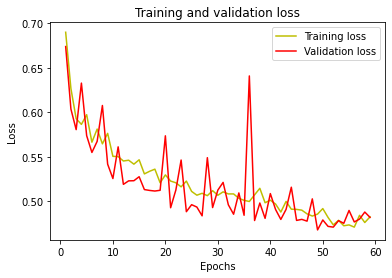

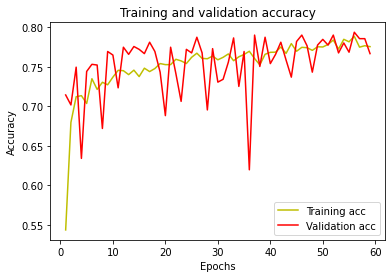

In [14]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### **PreTrained Model (VGG16)**

In [15]:
# Defining VGG16 Model
from tensorflow.keras.applications import VGG16
model2 = Sequential()
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(50, 50, 3))

model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='sigmoid'))
model2.summary()

#compile the VGG16
model2.compile(optimizer=Adam(0.001),
          loss='binary_crossentropy',
          metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                16416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 14,731,170
Trainable params: 14,731,170
Non-trainable params: 0
_________________________________________________________________


In [16]:
batch_size = 64
epochs = 100

# without data augmentation
history2 = model2.fit(X_train, y_train,
epochs=100,
validation_data=(X_test, y_test), batch_size=batch_size, callbacks=callback)
print(len(history2.history['loss']))

# #Data augmentation
# datagen2 = ImageDataGenerator(zoom_range=0.05,      
#                              rotation_range=45,
#                              fill_mode="nearest",
#                              horizontal_flip = True,
#                              brightness_range=(0.5,1.5),
#                              vertical_flip=True)

# datagen2.fit(X_train)
# #fit the model
# history2 = model2.fit(datagen2.flow(X_train,y_train,batch_size = batch_size),
#                                steps_per_epoch=(len(X_train)/batch_size),epochs=epochs,
#                                validation_data=(X_test,y_test),validation_steps=(len(X_test)/batch_size), callbacks=callback)
# print(len(history2.history['loss']))

Epoch 1/100
70/70 [==============================] - 8s 86ms/step - loss: 0.7044 - accuracy: 0.4891 - val_loss: 0.6930 - val_accuracy: 0.5099
Epoch 2/100
70/70 [==============================] - 5s 69ms/step - loss: 0.6895 - accuracy: 0.5389 - val_loss: 0.6691 - val_accuracy: 0.5243
Epoch 3/100
70/70 [==============================] - 5s 69ms/step - loss: 0.6562 - accuracy: 0.6324 - val_loss: 0.5883 - val_accuracy: 0.7459
Epoch 4/100
70/70 [==============================] - 5s 69ms/step - loss: 0.6075 - accuracy: 0.6973 - val_loss: 0.5899 - val_accuracy: 0.6649
Epoch 5/100
70/70 [==============================] - 5s 70ms/step - loss: 0.6131 - accuracy: 0.7005 - val_loss: 0.6047 - val_accuracy: 0.7459
Epoch 6/100
70/70 [==============================] - 5s 70ms/step - loss: 0.5850 - accuracy: 0.7246 - val_loss: 0.5172 - val_accuracy: 0.7658
Epoch 7/100
70/70 [==============================] - 5s 70ms/step - loss: 0.5661 - accuracy: 0.7334 - val_loss: 0.4973 - val_accuracy: 0.7793
Epoch 

In [17]:
#Evaluate the model
score2 = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy = ", (score2))
# test the classifier model:
preds=model2.predict(X_test)
preds
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(preds,axis=1)
print(confusion_matrix(y_test_arg, Y_pred))
print(classification_report(y_test_arg, Y_pred))

35/35 [==============================] - 1s 15ms/step - loss: 0.4747 - accuracy: 0.7910
Accuracy =  [0.47466403245925903, 0.7909910082817078]
[[426 118]
 [114 452]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       544
           1       0.79      0.80      0.80       566

    accuracy                           0.79      1110
   macro avg       0.79      0.79      0.79      1110
weighted avg       0.79      0.79      0.79      1110



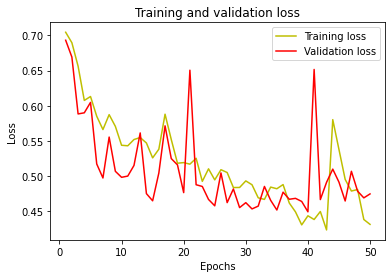

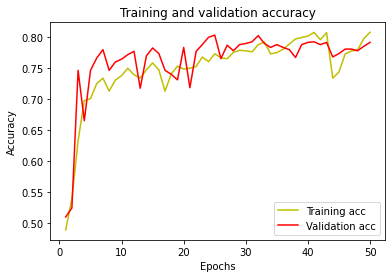

In [18]:
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### **PreTrianed Model (ResNet 50)**

In [19]:
resnet_50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
resnet_50.trainable=False

In [20]:
inputs = keras.Input(shape=(50,50,3))
x = resnet_50(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2, activation="sigmoid")(x)
modelr = keras.Model(inputs=inputs, outputs=outputs, name="my_model")
modelr.compile(optimizer=RMSprop(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
modelr.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [30]:
#Trian the model without data augmentation
historyr = modelr.fit(X_train, y_train,
epochs=200,
verbose=1,
validation_data=(X_test, y_test), batch_size=32, callbacks=callback)
print(len(historyr.history['loss']))

# #Data augmentation
# datagenr = ImageDataGenerator(zoom_range=0.05,      
#                              rotation_range=45,
#                              fill_mode="nearest",
#                              horizontal_flip = True,
#                              brightness_range=(0.5,1.5),
#                              vertical_flip=True)

# datagenr.fit(X_train)
# #fit the model
# historyr = modelr.fit(datagenr.flow(X_train,y_train,batch_size = batch_size),
#                                steps_per_epoch=(len(X_train)/batch_size),epochs=epochs,
#                                validation_data=(X_test,y_test),validation_steps=(len(X_test)/batch_size), callbacks=callback)
# print(len(historyr.history['loss']))

Epoch 1/200
139/139 [==============================] - 4s 25ms/step - loss: 0.5702 - accuracy: 0.7077 - val_loss: 0.5779 - val_accuracy: 0.7027
Epoch 2/200
139/139 [==============================] - 3s 21ms/step - loss: 0.5722 - accuracy: 0.7061 - val_loss: 0.5724 - val_accuracy: 0.7252
Epoch 3/200
139/139 [==============================] - 3s 21ms/step - loss: 0.5714 - accuracy: 0.7050 - val_loss: 0.5724 - val_accuracy: 0.7144
Epoch 4/200
139/139 [==============================] - 3s 21ms/step - loss: 0.5709 - accuracy: 0.7048 - val_loss: 0.5721 - val_accuracy: 0.7216
Epoch 5/200
139/139 [==============================] - 3s 21ms/step - loss: 0.5708 - accuracy: 0.7059 - val_loss: 0.5731 - val_accuracy: 0.7225
Epoch 6/200
139/139 [==============================] - 3s 21ms/step - loss: 0.5704 - accuracy: 0.7061 - val_loss: 0.5732 - val_accuracy: 0.7207
Epoch 7/200
139/139 [==============================] - 3s 23ms/step - loss: 0.5710 - accuracy: 0.7063 - val_loss: 0.5744 - val_accuracy:

In [31]:
#Evaluate the model
scorer = modelr.evaluate(X_test, y_test, verbose=1)
print("Accuracy = ", (scorer))
# test the classifier model:
preds=modelr.predict(X_test)
preds
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(preds,axis=1)
print(confusion_matrix(y_test_arg, Y_pred))
print(classification_report(y_test_arg, Y_pred))

35/35 [==============================] - 1s 20ms/step - loss: 0.5720 - accuracy: 0.7180
Accuracy =  [0.5720462799072266, 0.7180179953575134]
[[414 130]
 [183 383]]
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       544
           1       0.75      0.68      0.71       566

    accuracy                           0.72      1110
   macro avg       0.72      0.72      0.72      1110
weighted avg       0.72      0.72      0.72      1110



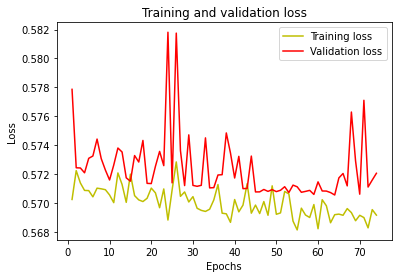

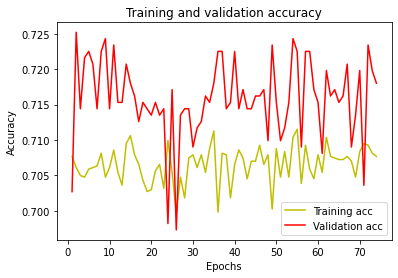

In [32]:
#plot the training and validation accuracy and loss at each epoch
loss = historyr.history['loss']
val_loss = historyr.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = historyr.history['accuracy']
val_acc = historyr.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### **AutoEncoders (U-NET) for semantic segmentation**

In [24]:
# from skimage.transform import resize
# x = resize(X, (5547, 64, 64, 3))
# #x = resize(x, (5547, 32, 32, 3))
# x.shape

(5547, 64, 64, 3)

In [25]:
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
# from tensorflow.keras.models import Model

# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     return x

# def encoder_block(input, num_filters):
#     x = conv_block(input, num_filters)
#     p = MaxPool2D((2, 2))(x)
#     return x, p

# def decoder_block(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# def build_unet(input_shape):
#     inputs = Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     b1 = conv_block(p4, 1024)

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

#     model = Model(inputs, outputs, name="U-Net")
#     return model

if __name__ == "__main__":
    input_shape = (64, 64, 3)
    modelu = build_unet(input_shape)
    modelu.summary()


modelr.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 64, 64, 64)   1792        ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d_4[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation_2 (Activation)      (None, 64, 64, 64)   0           ['batch_normalization[0][0]']

In [26]:
# modelu = build_unet(input_shape)
# modelu.compile(
#         loss="binary_crossentropy",
#         optimizer='adam',
#         metrics=[
#             tf.keras.metrics.MeanIoU(num_classes=2),
#             tf.keras.metrics.Recall(),
#             tf.keras.metrics.Precision()])